In [56]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import itertools
from torchvision.utils import make_grid

In [57]:
batch_size = 3
data_path = './gan-getting-started'

lr = 0.0002
b1 = 0.5
b2 = 0.999

n_epoches = 100
decay_epoch = 20

In [58]:
class img_dataset(Dataset):
    def __init__(self, data_path, train=True, transformer=None):
        monet_path = os.path.join(data_path, 'monet_jpg')
        photot_path = os.path.join(data_path, 'photo_jpg')
        
        if train:
            self.files_monet = [os.path.join(monet_path, name) for name in sorted(os.listdir(monet_path))[:250]]
            self.files_photot = [os.path.join(photot_path, name) for name in sorted(os.listdir(photot_path))[:250]]
        else:
            self.files_monet = [os.path.join(monet_path, name) for name in sorted(os.listdir(monet_path))[250:]]
            self.files_photot = [os.path.join(photot_path, name) for name in sorted(os.listdir(photot_path))[250:301]]
        
        self.transformer = transformer
        
    def __len__(self):
        return len(self.files_monet)
    
    def __getitem__(self, index):
        file_monet = self.files_monet[index]
        file_photot = self.files_photot[index]
        
        img_monet = Image.open(file_monet)
        img_photot = Image.open(file_photot)
        
        if self.transformer is not None:
            img_monet = self.transformer(img_monet)
            img_photot = self.transformer(img_photot)
        
        return img_monet, img_photot

In [59]:
transformers = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainloader = DataLoader(
    img_dataset(data_path, train=True, transformer=transformers),
    batch_size = batch_size,
    shuffle = True,
    num_workers = 0
)

testloader = DataLoader(
    img_dataset(data_path, train=False, transformer=transformers),
    batch_size = batch_size,
    shuffle = False,
    num_workers = 0
)


In [60]:
class Residualphototlock(nn.Module):
    def __init__(self, in_channels):
        super(Residualphototlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3), 
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )
    def forward(self, x):
        return x + self.block(x)

In [61]:
class GeneratorResNet(nn.Module):       #生成器
    def __init__(self, in_channels, num_residual_blocks = 9):
        super(GeneratorResNet, self).__init__()
        
#3 * 256 * 256 -> 64 * 256 * 256
        out_channels = 64        
        self.conv = nn.Sequential(
                    nn.ReflectionPad2d(in_channels), 
                    nn.Conv2d(in_channels, out_channels, 2*in_channels + 1),
                    nn.InstanceNorm2d(out_channels),
                    nn.ReLU(inplace=True))
        channels = out_channels
        
#64 * 256 * 256 -> 128 * 128 * 128 -> 256 * 64 * 64
        self.down = []
        for _ in range(2):
            out_channels = channels * 2
            self.down += [
                nn.Conv2d(channels, out_channels, 3, stride = 2, padding = 1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            channels = out_channels
        self.down = nn.Sequential(*self.down)
        
#256 * 64 * 64  残差连接
        self.trans = [Residualphototlock(channels) for _ in range(num_residual_blocks)]
        self.trans = nn.Sequential(*self.trans)
        
#256 * 64 * 64 -> 128 * 128 * 128 -> 64 * 256 * 256  上采样，还原图片
        self.up = []
        
        for _ in range(2):
            out_channels = channels // 2
            self.up += [
                nn.Upsample(scale_factor = 2),
                nn.Conv2d(channels, out_channels, 3, stride= 1, padding = 1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            channels = out_channels
        self.up = nn.Sequential(*self.up)
        
#64*256*256 -> 3*256*256
        self.out = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(channels, in_channels, 2*in_channels+1),
            nn.Tanh()
        )
        
    def forward(self, x, idea):
        x = self.conv(x)
        x = self.down(x)
        x = x + idea
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        
        return x

In [62]:
class Discriminator(nn.Module):         #判别器
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            *self.block(in_channels, 64, normalize = False), # 3 * 256 * 256 -> 64*128*128
            *self.block(64, 128), # 64 * 128 * 128 -> 128*64*64
            *self.block(128, 256),# 128 * 64 * 64 -> 256*32*32
            *self.block(256, 512), # 256 * 32 * 32 -> 512*16*16    
            nn.ZeroPad2d((1, 0, 1, 0)), # 512 * 16 * 16 -> 512 * 17 * 17
            nn.Conv2d(512, 1, 4, padding = 1) # 512 * 17 * 17 -> 1 * 16 * 16
        )
        self.scale_factor = 16
        
    @staticmethod
    def block(in_channels, out_channels, normalize = True):
        layers = [nn.Conv2d(in_channels, out_channels, 4 , stride = 2, padding = 1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
    
    def forward(self, x):
        return self.model(x)

In [63]:
criterion_GmonetN = nn.MSELoss().cuda()
criterion_cycle = nn.L1Loss().cuda()
criterion_identity = nn.L1Loss().cuda()

G_monet_to_photo = GeneratorResNet(3, num_residual_blocks=9).cuda()     #用于将莫奈的画生成为虚假照片的生成器
D_cycle  = Discriminator(3).cuda()                                      #用于对生成的虚假照片和真实照片进行判断的判别器

G_photo_to_monet = GeneratorResNet(3, num_residual_blocks=9).cuda()     #用于将真实的照片生成为虚假的莫奈画的生成器
D_real_monet_or_not = Discriminator(3).cuda()                           #用于对生成的虚假的画和真实的莫奈的画进行判断的判别器

In [64]:
optimizer_G = torch.optim.Adam(
    itertools.chain(G_monet_to_photo.parameters(), G_photo_to_monet.parameters()), lr=lr, betas=(b1, b2)
)

optimizer_D_cycle = torch.optim.Adam(
    D_cycle.parameters(), lr=lr, betas=(b1, b2)
)

optimizer_D_real_monet_or_not = torch.optim.Adam(
    D_real_monet_or_not.parameters(), lr=lr, betas=(b1, b2)
)

lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)   #根据epoch数量调整学习率

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)

lr_scheduler_D_cycle = torch.optim.lr_scheduler.LambdaLR(optimizer_D_cycle, lr_lambda=lambda_func)
lr_scheduler_D_real_monet_or_not = torch.optim.lr_scheduler.LambdaLR(optimizer_D_real_monet_or_not, lr_lambda=lambda_func)

In [65]:
#画图
def sample_images(real_monet, real_photo, figside=1.5):
    assert real_monet.size() == real_photo.size(), 'The image size for two domains must be the same'
    
    G_monet_to_photo.eval()
    G_photo_to_monet.eval()
    
    real_monet = real_monet.type(torch.cuda.FloatTensor)
    z = torch.randn(256,64,64).cuda()
    fake_photo = G_monet_to_photo(real_monet,z).detach()
    real_photo = real_photo.type(torch.cuda.FloatTensor)
    z = torch.randn(256,64,64).cuda()
    fake_monet = G_photo_to_monet(real_photo,z).detach()
    
    nrows = real_monet.size(0)
    real_monet = make_grid(real_monet, nrow=nrows, normalize=True)
    fake_photo = make_grid(fake_photo, nrow=nrows, normalize=True)
    real_photo = make_grid(real_photo, nrow=nrows, normalize=True)
    fake_monet = make_grid(fake_monet, nrow=nrows, normalize=True)
    
    image_grid = torch.cat((real_monet, fake_photo, real_photo, fake_monet), 1).cpu().permute(1, 2, 0)
    
    plt.figure(figsize=(figside*nrows, figside*4))
    plt.imshow(image_grid)
    plt.axis('off')
    plt.show()

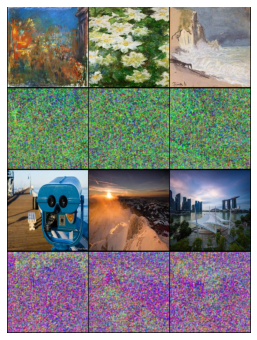

In [66]:
if __name__ == '__main__':
    real_monet, real_photo = next(iter(testloader))
    sample_images(real_monet, real_photo)

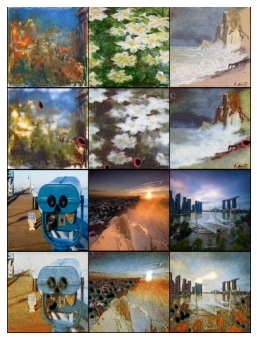

[Epoch 10/100]
[G loss: 4.888496398925781 | identity: 0.23469239473342896 GmonetN: 0.37927335500717163 cycle: 0.33357611298561096]
[D loss: 0.25550949573516846 | D_real_monet_or_not: 0.1916997879743576 D_cycle: 0.3193191885948181]


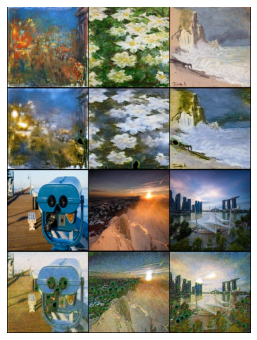

[Epoch 20/100]
[G loss: 2.5254154205322266 | identity: 0.16244065761566162 GmonetN: 0.5134621858596802 cycle: 0.1199750006198883]
[D loss: 0.22143198549747467 | D_real_monet_or_not: 0.27508535981178284 D_cycle: 0.1677786111831665]


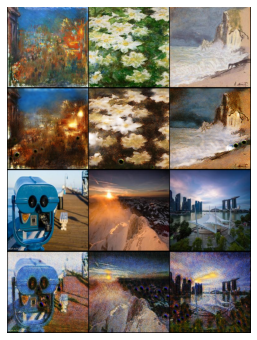

[Epoch 30/100]
[G loss: 3.2009196281433105 | identity: 0.16810469329357147 GmonetN: 0.7080479264259338 cycle: 0.16523481905460358]
[D loss: 0.0686974748969078 | D_real_monet_or_not: 0.05669945478439331 D_cycle: 0.0806954950094223]


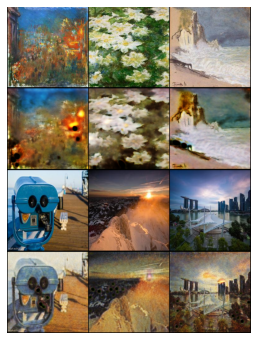

[Epoch 40/100]
[G loss: 3.8959202766418457 | identity: 0.22166131436824799 GmonetN: 0.7658050060272217 cycle: 0.2021808624267578]
[D loss: 0.04978204518556595 | D_real_monet_or_not: 0.04788753017783165 D_cycle: 0.05167655646800995]


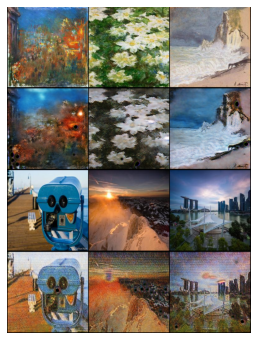

[Epoch 50/100]
[G loss: 3.408717632293701 | identity: 0.18698009848594666 GmonetN: 0.4654175937175751 cycle: 0.20083993673324585]
[D loss: 0.11227249354124069 | D_real_monet_or_not: 0.08972074091434479 D_cycle: 0.1348242461681366]


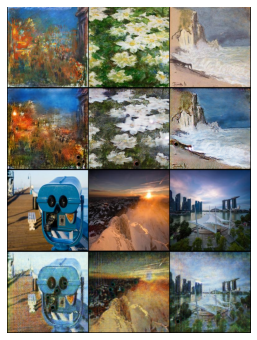

[Epoch 60/100]
[G loss: 3.12083101272583 | identity: 0.19852732121944427 GmonetN: 0.5337439775466919 cycle: 0.15944506227970123]
[D loss: 0.14571812748908997 | D_real_monet_or_not: 0.1430235654115677 D_cycle: 0.14841267466545105]


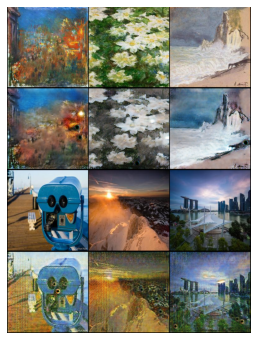

[Epoch 70/100]
[G loss: 3.674236297607422 | identity: 0.18817809224128723 GmonetN: 0.9002503156661987 cycle: 0.18330955505371094]
[D loss: 0.05483752489089966 | D_real_monet_or_not: 0.043644096702337265 D_cycle: 0.06603095680475235]


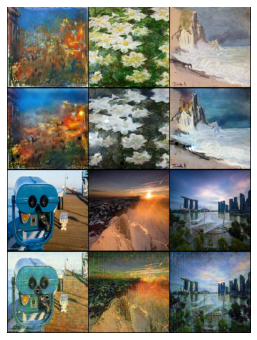

[Epoch 80/100]
[G loss: 2.8866689205169678 | identity: 0.17038464546203613 GmonetN: 0.6549115180969238 cycle: 0.13798341155052185]
[D loss: 0.04955560714006424 | D_real_monet_or_not: 0.051505014300346375 D_cycle: 0.047606199979782104]


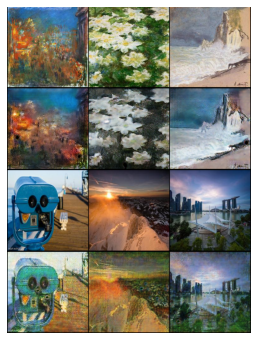

[Epoch 90/100]
[G loss: 2.8690266609191895 | identity: 0.18510450422763824 GmonetN: 0.7628392577171326 cycle: 0.11806648969650269]
[D loss: 0.02711845561861992 | D_real_monet_or_not: 0.03321007266640663 D_cycle: 0.021026836708188057]


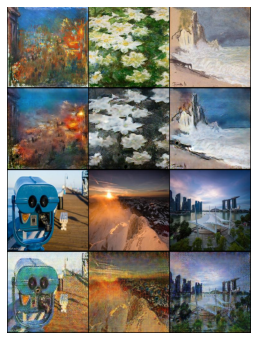

[Epoch 100/100]
[G loss: 3.4803590774536133 | identity: 0.2059830278158188 GmonetN: 0.6922491788864136 cycle: 0.1758194863796234]
[D loss: 0.05270760878920555 | D_real_monet_or_not: 0.08084836602210999 D_cycle: 0.024566849693655968]


In [67]:
for epoch in range(n_epoches):
    for i, (real_monet, real_photo) in enumerate(trainloader):
        real_monet, real_photo = real_monet.type(torch.cuda.FloatTensor), real_photo.type(torch.cuda.FloatTensor)
        
        # valid和fake用来在生成虚假图片or虚假画后，将其扔给判别器后计算MSE损失时使用
        out_shape = [real_monet.size(0), 1, real_monet.size(2)//D_real_monet_or_not.scale_factor, real_monet.size(3)//D_real_monet_or_not.scale_factor]
        valid = torch.ones(out_shape).type(torch.cuda.FloatTensor)
        fake = torch.zeros(out_shape).type(torch.cuda.FloatTensor)
        
        """Train Generators"""
        #保证只有两个生成器在进行训练以及反向梯度计算，而两个判别器参数固定。
        G_monet_to_photo.train()
        G_photo_to_monet.train()
        
        optimizer_G.zero_grad()
        #下面的z均表示idea，即认为是画家在作画时的灵感。
        z = torch.randn(256,64,64).cuda()
        fake_photo = G_monet_to_photo(real_monet,z)
        z = torch.randn(256,64,64).cuda()
        fake_monet = G_photo_to_monet(real_photo,z)
        
        # 判断生成器生成出来的虚假照片or虚假画与生成前的画or照片之间的差异，使用L1损失。
        loss_id_monet = criterion_identity(fake_photo, real_monet)
        loss_id_photot = criterion_identity(fake_monet, real_photo)
        loss_identity = (loss_id_monet + loss_id_photot) / 2
        
        # 判断生成器生成出来的虚假照片or虚假画能否被判别器所识别，使用MSE损失。
        loss_GAN_monet_to_photo = criterion_GmonetN(D_cycle(fake_photo), valid) 
        loss_GAN_photo_to_monet = criterion_GmonetN(D_real_monet_or_not(fake_monet), valid)
        loss_GAN = (loss_GAN_monet_to_photo + loss_GAN_photo_to_monet) / 2
        
        # 判断生成器生成出来的虚假照片or虚假画再通过另一个生成器还原回去后，其与原始画or照片之间的差异，使用L1损失
        z = torch.randn(256,64,64).cuda()
        recov_monet = G_photo_to_monet(fake_photo,z)
        z = torch.randn(256,64,64).cuda()
        recov_photo = G_monet_to_photo(fake_monet,z)
        loss_cycle_monet = criterion_cycle(recov_monet, real_monet)
        loss_cycle_photo = criterion_cycle(recov_photo, real_photo)
        loss_cycle = (loss_cycle_monet + loss_cycle_photo) / 2
        
        # 计算合计损失，其中权重可调整
        loss_G = 5.0*loss_identity + loss_GAN + 10.0*loss_cycle
        
        loss_G.backward()
        optimizer_G.step()
        
        """Train Discriminator monet"""
        optimizer_D_real_monet_or_not.zero_grad()
        
        loss_real = criterion_GmonetN(D_real_monet_or_not(real_monet), valid)
        loss_fake = criterion_GmonetN(D_real_monet_or_not(fake_monet.detach()), fake)
        loss_D_real_monet_or_not = (loss_real + loss_fake) / 2
        
        loss_D_real_monet_or_not.backward()
        optimizer_D_real_monet_or_not.step()
        
        """Train Discriminator photot"""
        optimizer_D_cycle.zero_grad()
        
        loss_real = criterion_GmonetN(D_cycle(real_photo), valid)
        loss_fake = criterion_GmonetN(D_cycle(fake_photo.detach()), fake)
        loss_D_cycle = (loss_real + loss_fake) / 2
        
        loss_D_cycle.backward()
        optimizer_D_cycle.step()
    
    lr_scheduler_G.step()
    lr_scheduler_D_real_monet_or_not.step()
    lr_scheduler_D_cycle.step()
    
    # test
    if (epoch+1) % 10 == 0:
        test_real_monet, test_real_photo = next(iter(testloader))
        sample_images(test_real_monet, test_real_photo)

        loss_D = (loss_D_real_monet_or_not + loss_D_cycle) / 2
        print(f'[Epoch {epoch+1}/{n_epoches}]')
        print(f'[G loss: {loss_G.item()} | identity: {loss_identity.item()} GmonetN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
        print(f'[D loss: {loss_D.item()} | D_real_monet_or_not: {loss_D_real_monet_or_not.item()} D_cycle: {loss_D_cycle.item()}]')   

In [70]:
photo_path = os.path.join(data_path, 'photo_jpg')
photos = [os.path.join(photo_path, name) for name in os.listdir(photo_path)]

save_path = './images'
if not os.path.exists(save_path):
    os.makepaths(save_path)

generate_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

to_image = transforms.ToPILImage()

G_photo_to_monet.eval()

for i in range(0, len(photos), batch_size):
    # read images
    imgs = []
    for j in range(i, min(len(photos), i+batch_size)):
        img = Image.open(photos[j])
        img = generate_transformer(img)
        imgs.append(img)
    imgs = torch.stack(imgs, 0).type(torch.cuda.FloatTensor)
    
    # generate
    z = torch.randn(256,64,64).cuda()
    fake_imgs = G_photo_to_monet(imgs,z).detach().cpu()
    
    # save
    for j in range(fake_imgs.size(0)):
        img = fake_imgs[j].squeeze().permute(1, 2, 0)
        img_arr = img.numpy()
        img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
        img_arr = img_arr.astype(np.uint8)
        
        img = to_image(img_arr)
        _, name = os.path.split(photos[i+j])
        img.save(os.path.join(save_path, name))
